<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 
# Spark MLlib Lesson.


___

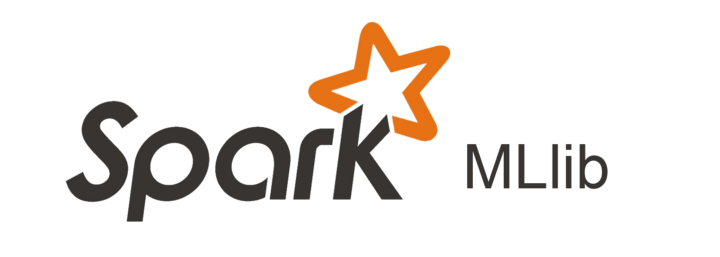

### Lesson Guide
- [Spark MLlib Intro](#intro)
- [Pipelines](#pipelines)
- [Classification & Regression](#models)
- [Lab](#lab)

<a id='intro'></a>
## Spark MLlib Intro

![](https://www.nobleprog.mx/sites/hitramx/files/styles/medium/public/category_image/apache-spark-mllib-training-in-mexico.png?itok=JFpgrQXn)

**MLlib** is Spark’s machine learning (ML) library. Its goal is to make **practical machine learning scalable and easy**.

At a high level, it provides tools such as:

- ML Algorithms: **common learning algorithms** such as classification, regression, clustering, and collaborative filtering
- Featurization: **feature extraction, transformation, dimensionality reduction, and selection**
- Pipelines: tools for **constructing, evaluating, and tuning ML Pipelines**
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

<a id='pipelines'></a>

## Pipelines

MLlib standardizes APIs for machine learning algorithms to make it easier to combine **multiple algorithms** (not models) into a single pipeline, or workflow. 

This is a feature **heavily inspired by sklearn's pipeline**.

In machine learning, it is common to **run a sequence of algorithms** to process and learn from data. E.g., a simple text document processing workflow might include several stages:

- Split each document’s **text into words**.
- Convert each document’s words into a **numerical feature vector**.
- **Learn a prediction model** using the feature vectors and labels.

MLlib represents such a workflow as a **Pipeline**, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. We will use this simple workflow as a running example in this section.


There are several first class *citizens* that we need to define in MLlib:

- **DataFrame**: The ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types.

- **Transformer**: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.

- **Estimator**: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.

- **Pipeline**: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

- **Parameter**: All Transformers and Estimators now share a common API for specifying parameters.

### Transformers
A Transformer is an abstraction that includes **feature transformers and learned models**. 
A Transformer implements a method `transform()`, which **converts one DataFrame into another**, generally by appending one or more columns. 

### Estimators

An Estimator abstracts the concept of a **learning algorithm or any algorithm** that fits or trains on data. 

An Estimator implements a method `fit()`, which accepts a DataFrame and produces a **Model**. 

The model itself is called a **Transformer**. 

For example, a learning algorithm such as LogisticRegression is an Estimator, and calling fit() trains a LogisticRegressionModel, which is a **Model and hence a Transformer**.

### Fitting everything together:

A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. 

These stages are run in order, and the input DataFrame is transformed as it passes through each stage. 

For Transformer stages, the `transform()` method is called on the DataFrame. 

For Estimator stages, the `fit()` method is called to **produce a Transformer** (which becomes part of the PipelineModel, or fitted Pipeline), and that **Transformer’s `transform()`** method is called on the DataFrame.

We illustrate this for the simple text document workflow, both for a **Pipeline and a PipelineModel**. 

The figure below is for the **training time usage** of a Pipeline:

![](http://spark.apache.org/docs/latest/img/ml-Pipeline.png)

If instead we wanted to generate predictions, we could also follow this flow:

![](http://spark.apache.org/docs/latest/img/ml-PipelineModel.png)

### Basic example of word processing and modelling:

In [1]:
import findspark
findspark.init('/usr/local/spark')

import pyspark as ps    # for the pyspark suite
import warnings         # for displaying warning
from pyspark.sql import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

In [2]:
try:
    # we try to create a SparkContext to work locally on all cpus available
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    # give a warning if SparkContext already exists (for use inside pyspark)
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [3]:
# sc.stop()

In [38]:
# Prepare training documents from a list of (id, text, label) tuples.
training = sqlContext.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

In [39]:
training.toPandas()

,id,text,label
0,0,a b c d e spark,1.0
1,1,b d,0.0
2,2,spark f g h,1.0
3,3,hadoop mapreduce,0.0


___

## We are going to create an ML pipeline:

### First we instantiate the estimators:

In [40]:
# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)

**Note:**  HashingTF requires only a single data scan and no additional memory beyond original input and vector. In comparison CountVectorizer requires additional scan over the data to build a model and additional memory to store vocabulary (index). In case of unigram language model it is usually not a problem but in case of higher n-grams it can be prohibitively expensive or not feasible.*

Scikit-learn has a similar algorithm: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html

### Add the stages to the Pipeline and fit it:

In [41]:
# Add the stages to the Pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [42]:
# Fit the pipeline to training documents.
model = pipeline.fit(training)

In [49]:
model.stages[2].coefficients

SparseVector(262144, {15554: 1.6237, 17222: 2.7805, 24152: 1.6237, 27526: -1.9274, 28698: 2.7805, 30913: -1.9274, 42633: -2.366, 51505: 1.6237, 155117: -2.366, 227410: 2.7805, 234657: 3.3031})

### Let's create some data:

In [50]:
# Prepare test documents, which are unlabeled (id, text) tuples.
test = sqlContext.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

### Finally use the pipeline to make prediction:

In [51]:
# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%2f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.15964077387874742,0.8403592261212527], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476743,0.16216743145232568], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976034,0.9307336686702395], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444218,0.01784246665557808], prediction=0.000000


<a id='models'></a>

## Classification and Regression

### Logistic regression

In spark.ml logistic regression can be used to predict a **binary outcome** by using **binomial logistic regression**, or it can be used to predict a **multiclass outcome** by using **multinomial logistic regression**.

In [59]:
# Load training data
training = sqlContext.read.format("libsvm").load("./datasets/sample_libsvm_data.txt")

In [60]:
training.toPandas().columns

Index(['label', 'features'], dtype='object')

In [61]:
training.toPandas().features[0]

SparseVector(692, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0, 356: 253.0, 357: 252.0,

In [62]:
training.toPandas().label.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64

In [63]:
training.toPandas().label.unique()

array([0., 1.])

In [64]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

In [67]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (692,[244,263,272,300,301,328,350,351,378,379,405,406,407,428,433,434,455,456,461,462,483,484,489,490,496,511,512,517,539,540,568],[-7.353983524188197e-05,-9.102738505589466e-05,-0.00019467430546904298,-0.00020300642473486668,-3.1476183314863995e-05,-6.842977602660743e-05,1.5883626898239883e-05,1.4023497091372047e-05,0.00035432047524968605,0.00011443272898171087,0.00010016712383666666,0.0006014109303795481,0.0002840248179122762,-0.00011541084736508837,0.000385996886312906,0.000635019557424107,-0.00011506412384575676,-0.00015271865864986808,0.0002804933808994214,0.0006070117471191634,-0.0002008459663247437,-0.0001421075579290126,0.0002739010341160883,0.00027730456244968115,-9.838027027269332e-05,-0.0003808522443517704,-0.00025315198008555033,0.00027747714770754307,-0.0002443619763919199,-0.0015394744687597765,-0.00023073328411331293])
Intercept: 0.22456315961250325


In [68]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (692,[244,263,272,300,301,328,350,351,378,379,405,406,407,428,433,434,455,456,461,462,483,484,489,490,496,511,512,517,539,540,568],[-7.353983524188197e-05,-9.102738505589466e-05,-0.00019467430546904298,-0.00020300642473486668,-3.1476183314863995e-05,-6.842977602660743e-05,1.5883626898239883e-05,1.4023497091372047e-05,0.00035432047524968605,0.00011443272898171087,0.00010016712383666666,0.0006014109303795481,0.0002840248179122762,-0.00011541084736508837,0.000385996886312906,0.000635019557424107,-0.00011506412384575676,-0.00015271865864986808,0.0002804933808994214,0.0006070117471191634,-0.0002008459663247437,-0.0001421075579290126,0.0002739010341160883,0.00027730456244968115,-9.838027027269332e-05,-0.0003808522443517704,-0.00025315198008555033,0.00027747714770754307,-0.0002443619763919199,-0.0015394744687597765,-0.00023073328411331293])
Intercept: 0.22456315961250325


### We can also use the multinomial classification

In [69]:
training = sqlContext.read.format("libsvm").load("./datasets/sample_multiclass_classification_data.txt")

In [70]:
training.toPandas().head()

,label,features
0,1.0,"(-0.222222, 0.5, -0.762712, -0.833333)"
1,1.0,"(-0.555556, 0.25, -0.864407, -0.916667)"
2,1.0,"(-0.722222, -0.166667, -0.864407, -0.833333)"
3,1.0,"(-0.722222, 0.166667, -0.694915, -0.916667)"
4,0.0,"(0.166667, -0.416667, 0.457627, 0.5)"


In [71]:

mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(training)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Multinomial coefficients: DenseMatrix([[ 0.        ,  0.        ,  0.        ,  0.31764832],
             [ 0.        ,  0.        , -0.78039435, -0.37696114],
             [ 0.        ,  0.        ,  0.        ,  0.        ]])
Multinomial intercepts: [0.05165231659832854,-0.12391224990853622,0.07225993331020768]


### The spark.ml implementation of logistic regression also supports extracting a **summary** of the model over the training set:

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data
training = sqlContext.read.format("libsvm").load("./datasets/sample_libsvm_data.txt")

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

training.show(5)

# Fit the model
lrModel = lr.fit(training)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[127,128,129...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[124,125,126...|
|  1.0|(692,[152,153,154...|
|  1.0|(692,[151,152,153...|
+-----+--------------------+
only showing top 5 rows



In [73]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

In [81]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.017543859649122806|
|0.0| 0.03508771929824561|
|0.0| 0.05263157894736842|
|0.0| 0.07017543859649122|
|0.0| 0.08771929824561403|
|0.0| 0.10526315789473684|
|0.0| 0.12280701754385964|
|0.0| 0.14035087719298245|
|0.0| 0.15789473684210525|
|0.0| 0.17543859649122806|
|0.0| 0.19298245614035087|
|0.0| 0.21052631578947367|
|0.0| 0.22807017543859648|
|0.0| 0.24561403508771928|
|0.0|  0.2631578947368421|
|0.0|  0.2807017543859649|
|0.0|  0.2982456140350877|
|0.0|  0.3157894736842105|
|0.0|  0.3333333333333333|
+---+--------------------+
only showing top 20 rows



In [82]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

areaUnderROC: 1.0


In [83]:
# Make predictions.
predictions = lrModel.transform(training)

# Select example rows to display.
predictions.select("prediction", "features").show(5)

+----------+--------------------+
|prediction|            features|
+----------+--------------------+
|       0.0|(692,[127,128,129...|
|       1.0|(692,[158,159,160...|
|       1.0|(692,[124,125,126...|
|       1.0|(692,[152,153,154...|
|       1.0|(692,[151,152,153...|
+----------+--------------------+
only showing top 5 rows



In [85]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
     predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))
print("Test Error = %g " % (1.0 - accuracy))

Accuracy = 0.98 
Test Error = 0.02 


## Decision Trees

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Load the data stored in LIBSVM format as a DataFrame.
data = sqlContext.read.format("libsvm").load("./datasets/sample_libsvm_data.txt")

In [87]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
"""
StringIndexer encodes a string column of labels to a column of label 
indices. The indices are in [0, numLabels), ordered by label frequencies,
so the most frequent label gets index 0.
"""
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

### This time we split the data into training and test sets (30% held out for testing)

In [88]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [89]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|(692,[95,96,97,12...|
|       1.0|         1.0|(692,[98,99,100,1...|
|       1.0|         1.0|(692,[100,101,102...|
|       1.0|         1.0|(692,[121,122,123...|
|       1.0|         1.0|(692,[122,123,148...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.0294118 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_48338c841768fb95e0f7) of depth 1 with 3 nodes


### Random Forests.

In [90]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = sqlContext.read.format("libsvm").load("./datasets/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# StringIndexer encodes a string column of labels to a column of label 
# indices. The indices are in [0, numLabels), ordered by label frequencies,
# so the most frequent label gets index 0.


In [91]:
labelIndexer.labels

['1.0', '0.0']

In [93]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [94]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

### We create a pipeline of estimators:

In [95]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

### And apply it:

In [96]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(692,[121,122,123...|
|           0.0|  0.0|(692,[125,126,127...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[126,127,128...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0
RandomForestClassificationModel (uid=rfc_85ef5ab170ae) with 10 trees


### Naive Bayes

In [97]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Load training data
data = sqlContext.read.format("libsvm") \
    .load("./datasets/sample_libsvm_data.txt")

# Split the data into train and test
splits = data.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))


+-----+--------------------+--------------------+-----------+----------+
|label|            features|       rawPrediction|probability|prediction|
+-----+--------------------+--------------------+-----------+----------+
|  0.0|(692,[95,96,97,12...|[-174115.98587057...|  [1.0,0.0]|       0.0|
|  0.0|(692,[98,99,100,1...|[-178402.52307196...|  [1.0,0.0]|       0.0|
|  0.0|(692,[100,101,102...|[-100905.88974016...|  [1.0,0.0]|       0.0|
|  0.0|(692,[123,124,125...|[-244784.29791241...|  [1.0,0.0]|       0.0|
|  0.0|(692,[123,124,125...|[-196900.88506109...|  [1.0,0.0]|       0.0|
|  0.0|(692,[124,125,126...|[-238164.45338794...|  [1.0,0.0]|       0.0|
|  0.0|(692,[124,125,126...|[-184206.87833381...|  [1.0,0.0]|       0.0|
|  0.0|(692,[127,128,129...|[-214174.52863813...|  [1.0,0.0]|       0.0|
|  0.0|(692,[127,128,129...|[-182844.62193963...|  [1.0,0.0]|       0.0|
|  0.0|(692,[128,129,130...|[-246557.10990301...|  [1.0,0.0]|       0.0|
|  0.0|(692,[152,153,154...|[-208282.08496711...|  

### Linear Regression

In [98]:
from pyspark.ml.regression import LinearRegression

# Load training data
training = sqlContext.read.format("libsvm")\
    .load("./datasets/sample_linear_regression_data.txt")

In [99]:
training.toPandas().head()

,label,features
0,-9.490010,"(0.4551273600657362, 0.36644694351969087, -0.3..."
1,0.257782,"(0.8386555657374337, -0.1270180511534269, 0.49..."
2,-4.438870,"(0.5025608135349202, 0.14208069682973434, 0.16..."
3,-19.782763,"(-0.0388509668871313, -0.4166870051763918, 0.8..."
4,-7.966594,"(-0.06195495876886281, 0.6546448480299902, -0...."


In [100]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,0.32292516677405936,-0.3438548034562218,1.9156017023458414,0.05288058680386263,0.765962720459771,0.0,-0.15105392669186682,-0.21587930360904642,0.22025369188813426]
Intercept: 0.1598936844239736
+--------------------+
|           residuals|
+--------------------+
|  -9.889232683103197|
|  0.5533794340053554|
|  -5.204019455758823|
| -20.566686715507508|
|    -9.4497405180564|
|  -6.909112502719486|
|  -10.00431602969873|
|   2.062397807050484|
|  3.1117508432954772|
| -15.893608229419382|
|  -5.036284254673026|
|   6.483215876994333|
|  12.429497299109002|
|  -20.32003219007654|
| -2.0049838218725005|
| -17.867901734183793|
|   7.646455887420495|
| -2.2653482182417406|
|-0.10308920436195645|
|  -1.380034070385301|
+--------------------+
only showing top 20 rows

RMSE: 10.189077
r2: 0.022861


## Model selection

An important task in ML is **model selection**, or using data to **find the best model or parameters** for a given task (also called tuning). 

Tuning may be done for **individual Estimators** such as LogisticRegression, or for **entire Pipelines** which include multiple algorithms, featurization, and other steps. 

Users can tune an **entire Pipeline at once** (wait, just like...?), rather than tuning each element in the Pipeline separately.

In [101]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training = sqlContext.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

### Gridsearch in MLlib:

We now treat the Pipeline as an **Estimator**, wrapping it in a **CrossValidator instance**.  

This will allow us to jointly choose parameters for all Pipeline stages.  
A **CrossValidator** requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.

We use a **ParamGridBuilder** to construct a grid of parameters to search over.  

With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
this grid will have 3 x 2 = 6 parameter settings for the CrossValidator to choose from.

In [103]:
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# the actual gridsearch
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

In [104]:
# Prepare test documents, which are unlabeled.
test = sqlContext.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text='spark i j k', probability=DenseVector([0.2661, 0.7339]), prediction=1.0)
Row(id=5, text='l m n', probability=DenseVector([0.9209, 0.0791]), prediction=0.0)
Row(id=6, text='mapreduce spark', probability=DenseVector([0.4429, 0.5571]), prediction=1.0)
Row(id=7, text='apache hadoop', probability=DenseVector([0.8584, 0.1416]), prediction=0.0)
